In [44]:
from numpy.random import RandomState
import numpy as np
np.set_printoptions(precision=2,suppress=True)

import matplotlib.pyplot as plt
import scipy.optimize as opt
from math import *

from scipy.optimize import basinhopping,minimize,differential_evolution

In [45]:
# define 3x3 patterns 

zv=[1,1,0,0,1,0,0,1,1]
vv=[1,0,1,1,0,1,0,1,0]
nv=[0,1,0,1,0,1,1,0,1]

def noisy(vector):
    result=[]
    for i in range(0,len(vector)):
        v=vector.copy()
        v[i]=np.logical_not(vector[i]).astype(int)
        #print(i,vector[i],v[i])
        result.append(v)
    return result

zpatterns=([zv]+noisy(zv))
vpatterns=([vv]+noisy(vv))
npatterns=([nv]+noisy(nv))

start=0
end=10
patterns=zpatterns[start:end]+vpatterns[start:end]+npatterns[start:end]
patterns_complete=zpatterns+vpatterns+npatterns

lenth=end-start

In [46]:
# basis functions, phi_pos, phi_neg
def transf_pos(x,K=2.0,y0=0.001,ym=1.5,n=2):
    result=ym*((x/K)**n)/(1+(x/K)**n)+ym*y0
    return result

def transf_neg(x,K=2.0,y0=0.001,ym=1.5,n=2):
    result=ym/(1+(x/K)**n)+y0*ym
    return result

In [47]:
# define global varaibles

size=3*3
target_L=0.0
target_H=1.2
patterns=patterns

lenth=int(len(patterns)/3)

target_0=np.array([target_H]*lenth+[target_L]*lenth+[target_L]*lenth)
target_1=np.array([target_L]*lenth+[target_H]*lenth+[target_L]*lenth)
target_2=np.array([target_L]*lenth+[target_L]*lenth+[target_H]*lenth)

target=target_0
#----
AHL_unit_level=33# uM 
transf_p=np.zeros(2)
transf_n=np.zeros(2)

transf_p[0]=transf_pos(x=0,K=50,y0=0.1,ym=1.0,n=0.45)
transf_p[1]=transf_pos(x=AHL_unit_level,K=50,y0=0.1,ym=1.0,n=0.45)
transf_n[0]=transf_neg(x=0,K=0.252,y0=0.341,ym=735,n=0.67)
transf_n[1]=transf_neg(x=AHL_unit_level,K=0.252,y0=0.341,ym=735,n=0.67)
  
#print(transf_p)
#print(transf_n)

phi_pos=np.array([transf_p]*size)
phi_neg=np.array([transf_n]*size)

In [48]:
def examine_output(w,P,phi_pos,phi_neg):
    y_n=np.zeros(len(P))
    w_ph_=np.zeros(len(P))

    for n in range(0,len(P)):
        pttn=np.array(P[n])
        
        phi_nw=(1.0+w/np.sqrt(w**2))/2*output_fcn(pttn,phi_pos)+\
            (1.0-w/np.sqrt(w**2))/2*output_fcn(pttn,phi_neg)/w
                
        w_ph_[n]=np.dot(w,phi_nw)/len(w)
        y_n[n]=activate(w_ph_[n])
        
    return y_n,w_ph_

def output_fcn(pttn,fcn):
    
    CHL_levels=np.zeros(len(pttn))
    for i in range(0,len(pttn)):
        CHL_levels[i]=fcn[i][pttn[i]]
        
    return CHL_levels

def activate(x):
    K,y0,ym_x,n= 1.10292919e+03,1.94584842e-02,2.15950963e+04,2.33038211e+00

    result=transf_pos(x.sum(),K=K,y0=y0/1e4,ym=2.0,n=n).sum()
    return result

In [49]:
def train_step1(target,size,eta,phi_pos,phi_neg):
    rndstate=RandomState(2)
    w=rndstate.random_sample(size)
    print('w: ',w)
    r=size

    w_series=[]
    y_series=[]
    delta_series=[]

    for it in range(0,350):
        y_n=np.zeros(len(patterns))
        g_n=np.zeros(len(patterns))
        delta_err=np.zeros(size)
        phi_n=[]
    
        for n in range(0,len(patterns)):
            pttn=np.array(patterns[n])
            # consider pttn as indexes in vector x, 0 means x[0], 1 means x[1]
        
            phi_nw=(1.0+w/np.sqrt(w**2))/2*output_fcn(pttn,phi_pos)+\
                (1.0-w/np.sqrt(w**2))/2*output_fcn(pttn,phi_neg)/w

            g_n[n]=np.dot(w,phi_nw)/r
            y_n[n]=activate(g_n[n])            
            
            tmp=(y_n[n]-target[n])
            tmp=min(target_H,tmp)

            phi_nw_pos=(1.0+w/np.sqrt(w**2))/2*output_fcn(pttn,phi_pos)                
            delta_err+=tmp*phi_nw_pos
        
        w=w-eta*delta_err 
        y_series.append(y_n)
        w_series.append(w)
        delta_series.append(delta_err)
    
    return w,y_series,w_series,delta_series

In [56]:
et=25
w0,y_series0,w_series0,d0=train_step1(target_0,size=3**2,eta=et,phi_pos=phi_pos,phi_neg=phi_neg)
output_0,_=examine_output(w0,patterns,phi_pos=phi_pos,phi_neg=phi_neg)
print(w0)
print(output_0)

#---------
w1,y_series1,w_series1,d1=train_step1(target_1,size=3**2,eta=et,phi_pos=phi_pos,phi_neg=phi_neg)
output_1,_=examine_output(w1,patterns,phi_pos=phi_pos,phi_neg=phi_neg)
print(w1)
print(output_1)

#---------
w2,y_series2,w_series2,d2=train_step1(target_2,size=3**2,eta=et,phi_pos=phi_pos,phi_neg=phi_neg)
output_2,_=examine_output(w2,patterns,phi_pos=phi_pos,phi_neg=phi_neg)
print(w2)
print(output_2)

w:  [0.44 0.03 0.55 0.44 0.42 0.33 0.2  0.62 0.3 ]
[ 913.19  913.15  -25.22  -28.38 7059.09  -28.48  -25.46  913.29  913.3 ]
[0.99 0.94 0.94 0.91 0.91 0.57 0.91 0.91 0.94 0.94 0.18 0.14 0.23 0.26
 0.26 0.6  0.26 0.12 0.14 0.23 0.18 0.23 0.14 0.12 0.26 0.6  0.26 0.26
 0.23 0.14]
w:  [0.44 0.03 0.55 0.44 0.42 0.33 0.2  0.62 0.3 ]
[ 913.19  -28.74 7059.1   913.26  -25.32  913.2   -25.48  913.29  -28.48]
[0.18 0.14 0.26 0.6  0.23 0.26 0.23 0.12 0.14 0.26 0.99 0.94 0.91 0.57
 0.94 0.91 0.94 0.91 0.94 0.91 0.18 0.23 0.26 0.6  0.14 0.12 0.14 0.26
 0.23 0.26]
w:  [0.44 0.03 0.55 0.44 0.42 0.33 0.2  0.62 0.3 ]
[ -28.41  913.17  -25.21  913.28  -25.28  913.22 7059.05  -28.24  913.31]
[0.18 0.26 0.14 0.12 0.23 0.26 0.23 0.6  0.26 0.14 0.18 0.26 0.23 0.26
 0.14 0.12 0.14 0.6  0.26 0.23 0.99 0.91 0.94 0.91 0.94 0.91 0.94 0.57
 0.91 0.94]


In [57]:
# eta=25
data_series3=dict()
data_series3['eta']=et
data_series3['w0']=w0
data_series3['y_series0']=y_series0
data_series3['w_series0']=w_series0
data_series3['d0']=d0
#---
data_series3['w1']=w1
data_series3['y_series1']=y_series1
data_series3['w_series1']=w_series1
data_series3['d1']=d1
#---
data_series3['w2']=w2
data_series3['y_series2']=y_series2
data_series3['w_series2']=w_series2
data_series3['d2']=d2

In [55]:
# eta=3.5
data_series2=dict()
data_series2['eta']=et
data_series2['w0']=w0
data_series2['y_series0']=y_series0
data_series2['w_series0']=w_series0
data_series2['d0']=d0
#---
data_series2['w1']=w1
data_series2['y_series1']=y_series1
data_series2['w_series1']=w_series1
data_series2['d1']=d1
#---
data_series2['w2']=w2
data_series2['y_series2']=y_series2
data_series2['w_series2']=w_series2
data_series2['d2']=d2

In [53]:
# eta=2.0
data_series1=dict()
data_series1['eta']=et
data_series1['w0']=w0
data_series1['y_series0']=y_series0
data_series1['w_series0']=w_series0
data_series1['d0']=d0
#---
data_series1['w1']=w1
data_series1['y_series1']=y_series1
data_series1['w_series1']=w_series1
data_series1['d1']=d1
#---
data_series1['w2']=w2
data_series1['y_series2']=y_series2
data_series1['w_series2']=w_series2
data_series1['d2']=d2

In [51]:
# eta=2.5
data_series0=dict()
data_series0['eta']=et
data_series0['w0']=w0
data_series0['y_series0']=y_series0
data_series0['w_series0']=w_series0
data_series0['d0']=d0
#---
data_series0['w1']=w1
data_series0['y_series1']=y_series1
data_series0['w_series1']=w_series1
data_series0['d1']=d1
#---
data_series0['w2']=w2
data_series0['y_series2']=y_series2
data_series0['w_series2']=w_series2
data_series0['d2']=d2

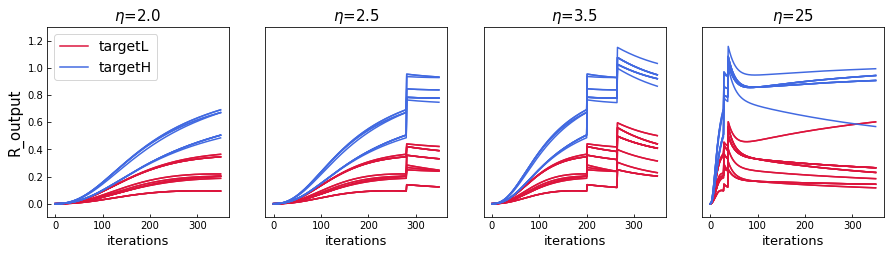

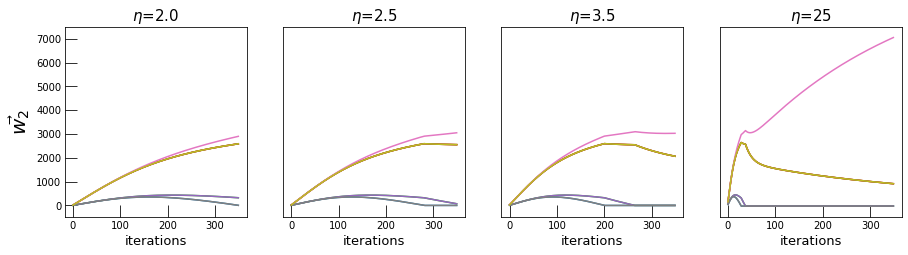

In [72]:
fig1=plt.figure(figsize=(15,3.5))
    
target=target_2                                           #change between weights
num=2
H_indx=20
L_indx=0

datas_=[data_series1,data_series0,data_series2,data_series3]

for k in range(0,len(datas_)):
    ax=fig1.add_subplot(1,len(datas_),k+1)
    y_series=datas_[k]['y_series'+str(num)]                           #change between weights
    
    for i in range(0,len(patterns)):
        if target[i]==target_H:
            if i==H_indx and k==0:
                ax.plot(np.array(y_series).T[i],color='royalblue',label='targetH')
            else:
                ax.plot(np.array(y_series).T[i],color='royalblue')
        
        if target[i]==target_L:
            if i==L_indx and k==0:
                ax.plot(np.array(y_series).T[i],color='crimson',label='targetL')
            else:
                ax.plot(np.array(y_series).T[i],color='crimson')
    
    ax.set_xlabel('iterations',fontsize=13)
    ax.tick_params(direction='in')
    ax.set_ylim([-0.1,1.3])
    ax.set_title('$\eta$='+str(datas_[k]['eta']),fontsize=15)
    if k==0:
        ax.set_ylabel('R_output',fontsize=15)
        ax.legend(loc='upper left',fontsize=14)
    else:
        ax.set_yticks([])

fig_path='/Users/ximing/Documents/technion_stuff/figures/'
plt.savefig(fig_path+'varying_eta_R_output'+str(num)+'.png',dpi=300)        #change between weights
        
#-----
fig2=plt.figure(figsize=(15,3.5))

for k in range(0,len(datas_)):
    ax=fig2.add_subplot(1,len(datas_),k+1)
    w_series=datas_[k]['w_series'+str(num)]                              #change between weights
    for i in range(0,size):
        ax.plot(np.array(w_series).T[i])             
        
    ax.set_xlabel('iterations',fontsize=13)
    ax.tick_params(direction='in',size=12)
    ax.set_ylim([-500,7500])
    ax.set_title('$\eta$='+str(datas_[k]['eta']),fontsize=15)
    if k==0:
        ax.set_ylabel('$\\vec{w_'+str(num)+'}$',fontsize=20)                 #change between weights
    else:
        ax.set_yticks([])

fig_path='/Users/ximing/Documents/technion_stuff/figures/'
plt.savefig(fig_path+'varying_eta_w'+str(num)+'.png',dpi=300)     #change between weights

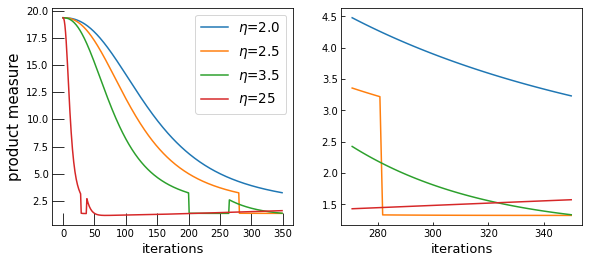

In [63]:
fig3=plt.figure(figsize=(9.5,4))

datas_=[data_series1,data_series0,data_series2,data_series3]
target=target_2                                                   #change between weights
num=2
ax1=fig3.add_subplot(121)
ax2=fig3.add_subplot(122)  #zoomed in 


for k in range(0,len(datas_)):
    yseries=np.array(datas_[k]['y_series'+str(num)])
    product=(2*yseries-target_H)*(2*target-target_H)
    measure_=np.var(product,axis=1)*10+(target_H**2-np.mean(product,axis=1))
    index=np.linspace(0,len(measure_),len(measure_))
    ax1.plot(measure_,label='$\eta$='+str(datas_[k]['eta']))
    ax2.plot(index[-80:],measure_[-80:])
    
ax1.legend(loc='upper right',fontsize=13.5)
ax1.set_xlabel('iterations',fontsize=13)
ax1.set_ylabel('product measure',fontsize=15)
ax1.tick_params(direction='in',size=12)

ax2.set_xlabel('iterations',fontsize=13)
ax2.tick_params(direction='in')

fig_path='/Users/ximing/Documents/technion_stuff/figures/'
plt.savefig(fig_path+'varying_eta_product_w'+str(num)+'.png',dpi=300)              #change between weights

In [32]:
# step2
# basinhopping method

def step2(w0):
    y=np.zeros(len(patterns))

    for n in range(0,len(patterns)):
        pttn=np.array(patterns[n])
        phi_nw=(1.0+w0/np.sqrt(w0**2))/2*output_fcn(pttn,phi_pos)+\
            (1.0-w0/np.sqrt(w0**2))/2*output_fcn(pttn,phi_neg)/w0
        y[n]=activate(np.dot(w0,phi_nw)/size)
        
    product=(2*y-target_H)*(2*target-target_H)
    
    return np.var(product)*10+(target_H**2-np.mean(product))

In [37]:
w=data_series0['w0']
target=target_0
minimizer_kwargs = {"method": "Nelder-Mead"}
res0=basinhopping(step2,w,minimizer_kwargs=minimizer_kwargs,niter=20)

print(res0.lowest_optimization_result.success)
w0_txt=", ".join("%.3f" % f for f in res0.x)
print(w0_txt)

True
1813.310
1813.310
-0.339
-2.281
2871.605
-2.109
-0.632
1813.310
1813.310


In [40]:
w=data_series0['w1']
target=target_1
minimizer_kwargs = {"method": "Nelder-Mead"}
res1=basinhopping(step2,w,minimizer_kwargs=minimizer_kwargs,niter=20)

print(res1.lowest_optimization_result.success)
w1_txt=", ".join("%.3f" % f for f in res1.x)
print(w1_txt)

True
1813.310, 1813.310, -0.339, -2.281, 2871.605, -2.109, -0.632, 1813.310, 1813.310


In [43]:
w=data_series0['w2']
target=target_2
minimizer_kwargs = {"method": "Nelder-Mead"}
res2=basinhopping(step2,w,minimizer_kwargs=minimizer_kwargs,niter=20)

print(res2.lowest_optimization_result.success)
w2_txt=", ".join("%.3f" % f for f in res2.x)
print(w2_txt)

True
-5.887, 1813.310, -0.311, 1813.310, -0.546, 1813.310, 2871.604, -0.539, 1813.310
